# Handwritten Digit Classification

In this project, you will build a machine learning algorithm to classify handwritten digits using image features. Starting with the provided dataset, your task is to develop a model that effectively solves this multiclass classification problem. Use the baseline notebook as a starting point and improve upon it.

## Introduction

In this project, you will work with a dataset of handwritten digit images. The dataset has been intentionally made messy: some images are missing labels, others are noisy or empty, and certain classes have more samples than others. Your task is to clean and organize this dataset to prepare it for analysis.

A basic, weak baseline model is provided to help you get started. This baseline is not intended to be accurate or comprehensive. Instead, it’s a starting point for you to improve upon by applying your own strategies to enhance data quality and model performance.

Formal details and specific tasks will be outlined at the end of this notebook. For now, focus on understanding the dataset and planning how to address its challenges.

## Assignment

**Please use only the provided dataset: no external datasets are allowed.**

**Use train subset only for training and test only for testing, and make sure not removing relevant samples during data cleaning/preprocessing.**

**The solution notebook MUST run without errors when executing all cells.**

Focus only on classical machine learning algorithms available in *sklearn* for your analysis, other than artificial neural networks.

You are welcome to experiment with models based on artificial neural networks, but these will not be evaluated.

### Tasks

1. **Data Visualization and Exploration**:
   - Visualize and analyze the dataset to gain insights into the distribution and characteristics of different features.
   - Consider visualizing the distribution of labels, pixel intensity distributions, and any additional features you extract.
   - After applying each filtering approach (e.g., removing irrelevant or noisy data), visualize how the data changes to verify the effectiveness of your method.
   - Analyze correlations between features to understand which ones are most important for classification and identify any redundant or highly correlated features.

2. **Handle Unlabeled and Irrelevant Data**:
   - Investigate the dataset for **unlabeled** data.
   - Identify and filter out **irrelevant images**, such as:
     - Empty images
     - Images containing white noise
     - Images containing only a large rectangle
   - Be careful when handling this noisy data, as it may affect model performance if not properly filtered.

3. **Feature Engineering and Preprocessing**:
   - Experiment with adding new features or refining the ones already provided (e.g., symmetry, pixel intensity histograms, edge detection).
   - Deal with **class imbalance** using methods such as oversampling, undersampling, class weighting, or data augmentation. Ensure you do not modify the test set when addressing class imbalance.
   - All images in the dataset contain slight noise. You may want to try applying denoising techniques (i.e. **median blur**, **Gaussian blur**, or **light smoothing filters**) to improve the quality of the input data.
   - Learn about and adjust feature extraction techniques to better capture the characteristics of the images and improve model performance.

4. **Apply Different Machine Learning Algorithms**:
   - Try various [machine learning algorithms](https://scikit-learn.org/1.5/supervised_learning.html) (e.g., Random Forest, SVM, k-Nearest Neighbors, Logistic Regression) to improve performance.
   - Evaluate the models not only based on the **overall accuracy**, but also consider the confusion matrix and **per-class performance**.
   - Compare and explain the effect of using different evaluation [metrics](https://scikit-learn.org/1.5/modules/model_evaluation.html) (e.g., precision, recall, F1-score) based on your findings from the exploratory data analysis.

## Baseline

Let's install all required dependencies:

- **datasets**: Provides access to large-scale datasets, including the one you'll work with.
- **scikit-learn**: Tools for classical machine learning algorithms and model evaluation.
- **matplotlib**: Plotting library for data visualization.
- **opencv-python**: Computer vision library for image processing.
- **scikit-image**: Image processing tools specifically designed for scientific tasks.
- **tqdm**: Displays progress bars to track loops and long operations.
- **pillow**: Image processing library

You might be familiar with most of these already.

In [1]:
%%capture
!pip install datasets scikit-learn matplotlib opencv-python scikit-image pillow

And import the modules

In [2]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog, local_binary_pattern
import cv2
from tqdm import tqdm
import pandas as pd
from collections import Counter
import random

### Dataset Description

The dataset consists of images of handwritten digits from 10 classes, representing the digits `0` through `9`. These images are grayscale and have been resized to a standard size (e.g., 28x28 pixels).

The dataset has been purposely modified to include some **unlabeled images**, **noisy samples**, and **synthetically augmented data** for certain classes. You will need to clean the data, handle the noise, and ensure that the dataset is ready for effective model training.

Basic preprocessing has been provided, but more advanced data cleaning and feature extraction will be a key part of your assignment.

Let's download the dataset using the Hugging Face datasets library and display first samples.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


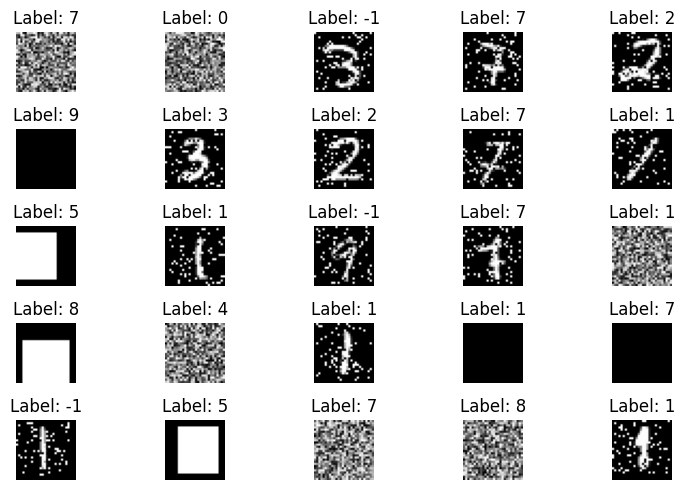

In [3]:
dataset = load_dataset("unibz-ds-course/image_assignment")
first_samples = dataset['train'].select(range(25))

images = first_samples['image']
labels = first_samples['label']

fig, axs = plt.subplots(5, 5, figsize=(8, 5))

for i, ax in enumerate(axs.flat):
    ax.imshow(np.array(images[i]), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

As we can see, the dataset contains various types of irrelevant images, such as empty images, unlabeled samples (**labeled as -1**), noisy images, and images containing large rectangles. The first two are straightforward to identify, while the last can be detected using OpenCV methods or (suggested) by binarizing images with a threshold and writing an algorithm to [find the largest rectangular area](https://www.geeksforgeeks.org/maximum-size-rectangle-binary-sub-matrix-1s/), making a decision based on its size percentage relative to the entire image.

These artifacts were intentionally introduced and will need to be identified and filtered out during the data cleaning process.

**During filtering, display a subset of the removed images. It is recommended to display at least 20–30 to ensure that images containing numbers are not mistakenly filtered out.**

Additionally, based on these initial samples, we can anticipate some imbalance in the dataset, which will require careful handling to ensure fair and accurate model training.


## Data cleaning for train set

### Filter Unlabeled (-1) and Empty Images (Purely Black or white)

The cleaning process began by identifying and removing images that were entirely black (all pixel values equal to 0) or entirely white (all pixel values equal to 255). Additionally, images with a label of -1 were also excluded.

In [4]:
def is_empty(image):
    return np.all(np.array(image) == 0) or np.all(np.array(image) == 255)

cleaned_data = [sample for sample in dataset['train'] if sample['label'] != -1 and not is_empty(sample['image'])]


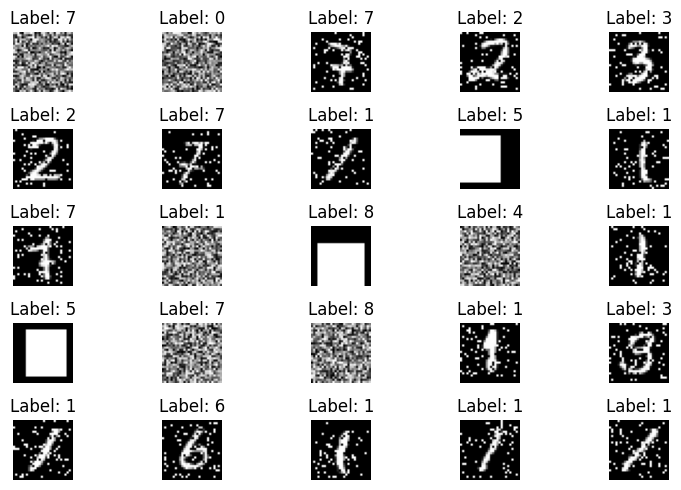

In [5]:
first_samples = cleaned_data[:25]

images = [sample['image'] for sample in first_samples]
labels = [sample['label'] for sample in first_samples]

fig, axs = plt.subplots(5, 5, figsize=(8, 5))

for i, ax in enumerate(axs.flat):
    ax.imshow(np.array(images[i]), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### Detect and remove samples with large rectangles and noise

To detect and remove samples containing large rectangles and noise, the dataset is processed using specific criteria. First, images with only two unique colors (e.g., pure black and white) are identified, as these are likely to contain large, distinct shapes such as rectangles without any gradients or shades of gray. This makes sense because such images lack complexity and variation typical of natural or meaningful content. Next, noisy images are detected by calculating the average pixel intensity; images with an average below a specified threshold are considered too dark or underexposed, likely representing noise rather than useful data.

In [6]:
def has_two_colors(image):
    img_np = np.array(image)

    unique_colors = np.unique(img_np)

    if len(unique_colors) == 2:
        return True
    return False

def is_not_noise(image, threshold=100):

    avg_intensity = np.mean(image)

    if avg_intensity < threshold:
        return True
    return False

filtered_data = [
    sample for sample in cleaned_data
    if not has_two_colors(sample['image']) and is_not_noise(sample['image'])
]

removed_data = [
    sample for sample in cleaned_data
    if has_two_colors(sample['image']) or not is_not_noise(sample['image'])
]


#### Displaying the resulting dataset after filtering

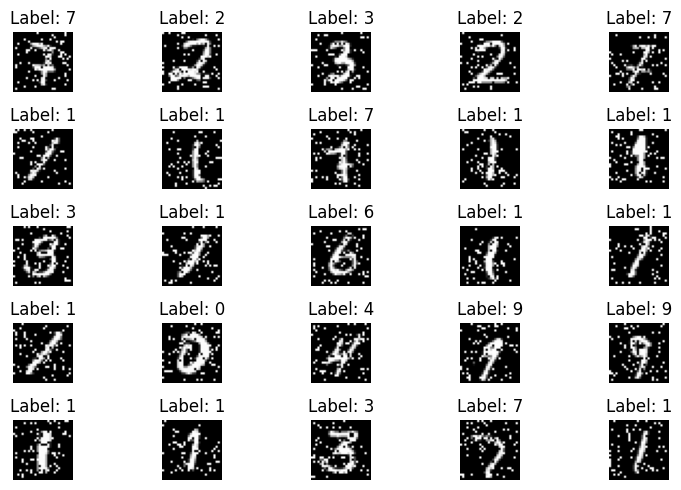

In [7]:
first_samples = filtered_data[:25]

images = [sample['image'] for sample in first_samples]
labels = [sample['label'] for sample in first_samples]

fig, axs = plt.subplots(5, 5, figsize=(8, 5))

for i, ax in enumerate(axs.flat):
    ax.imshow(np.array(images[i]), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Displaying the filtered out data

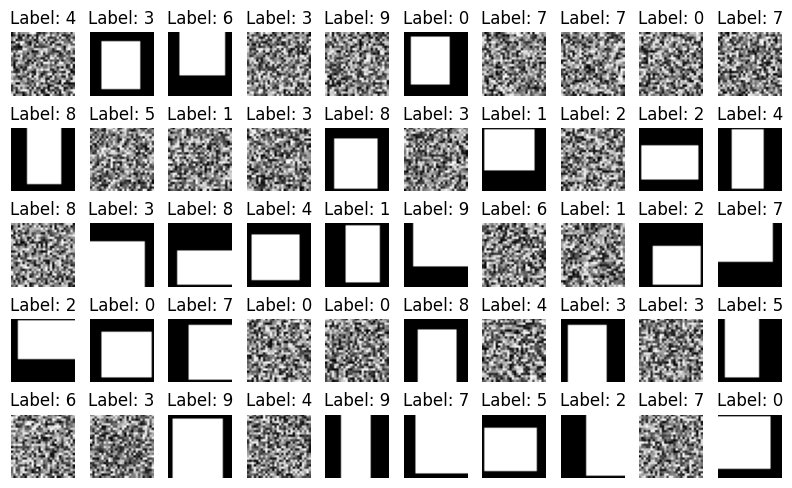

In [8]:
first_samples = removed_data[20:]

images = [sample['image'] for sample in first_samples]
labels = [sample['label'] for sample in first_samples]

fig, axs = plt.subplots(5, 10, figsize=(8, 5))

for i, ax in enumerate(axs.flat):
    ax.imshow(np.array(images[i]), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Data Cleaning for test set

We apply the same cleaning functions to the test set, removing images with a label of -1, images that are purely black or purely white, those containing large rectangles, and those identified as noisy.

In [9]:
def is_empty(image):
    return np.all(np.array(image) == 0) or np.all(np.array(image) == 255)

cleaned_data_test = [sample for sample in dataset['test'] if sample['label'] != -1 and not is_empty(sample['image'])]

In [10]:
filtered_data_test = [
    sample for sample in cleaned_data_test
    if not has_two_colors(sample['image']) and is_not_noise(sample['image'])]

### Displaying the resulting test dataset after filtering


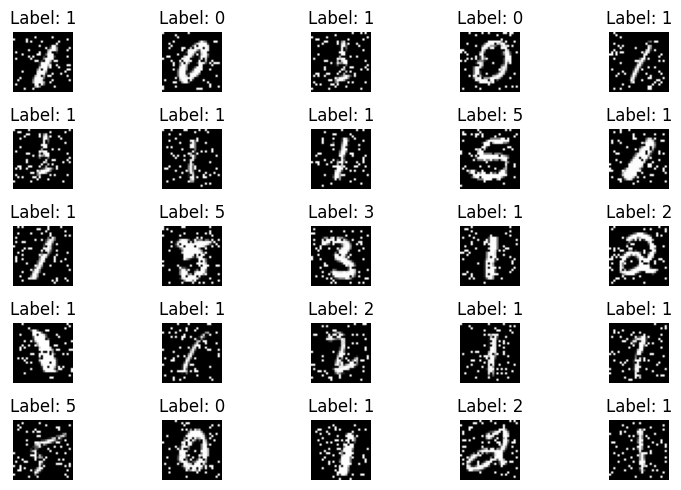

In [11]:
first_samples = filtered_data_test[:25]

images = [sample['image'] for sample in first_samples]
labels = [sample['label'] for sample in first_samples]

fig, axs = plt.subplots(5, 5, figsize=(8, 5))

for i, ax in enumerate(axs.flat):
    ax.imshow(np.array(images[i]), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Imbalance in Classes

From the visualization, you can observe an imbalance in the classes. To address this, consider applying techniques such as:

- **Oversampling**: Increase the number of samples in the minority class.
- **Undersampling**: Reduce the number of samples in the majority class.
- **Class Weighting**: Adjust model training by assigning different weights to classes. For most machine learning algorithms, class weighting is supported in **`sklearn`** by passing the `class_weight` parameter (see documentation e.g [Random Forest](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html).
- **Data Augmentation**: Generate more diverse data for underrepresented classes by transforming existing samples. This can include techniques like rotating, scaling, or adding noise to the images.

Make sure to **learn about these techniques** and how to implement them effectively in your workflow.

You can perform these modifications directly on **PIL** images or by using augmentation libraries such as **Albumentations**. Be careful to ensure that the augmentations maintain the integrity of the images, and **do not apply any augmentations to the test set**.

**Ensure that you do not modify the test set when addressing class imbalance.**

### Class Distribution

When examining the class distribution, it is evident that the label "1" is significantly overrepresented compared to the other labels.

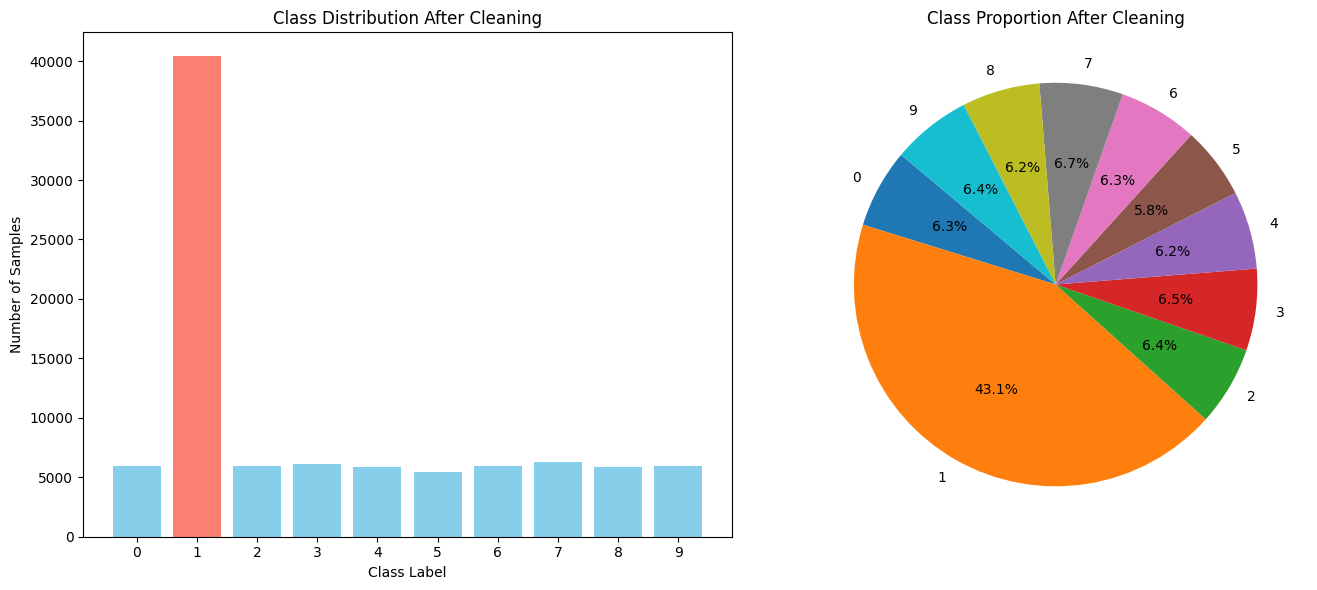

In [12]:
def plot_class_distribution_side_by_side(dataset):
    class_counts = Counter(sample['label'] for sample in dataset)

    sorted_labels = sorted(class_counts.keys())
    sorted_counts = [class_counts[label] for label in sorted_labels]

    colors = ['skyblue' if label != 1 else 'salmon' for label in sorted_labels]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].bar(sorted_labels, sorted_counts, color=colors)
    axes[0].set_xlabel("Class Label")
    axes[0].set_ylabel("Number of Samples")
    axes[0].set_title("Class Distribution After Cleaning")
    axes[0].set_xticks(sorted_labels)

    axes[1].pie(sorted_counts, labels=sorted_labels, autopct='%1.1f%%', startangle=140)
    axes[1].set_title("Class Proportion After Cleaning")

    plt.tight_layout()
    plt.show()

plot_class_distribution_side_by_side(filtered_data)


### Undersampling

Undersampling will address the imbalance by reducing the number of samples in the majority class.

In [13]:
def undersample_data(dataset, target_class_size=None):
    class_counts = Counter(sample['label'] for sample in dataset)

    if target_class_size is None:
        target_class_size = min(class_counts.values())

    undersampled_data = []

    for label, count in class_counts.items():
        class_samples = [sample for sample in dataset if sample['label'] == label]
        undersampled_data.extend(np.random.choice(class_samples, target_class_size, replace=False))

    return undersampled_data

### Class distribution after undersampling

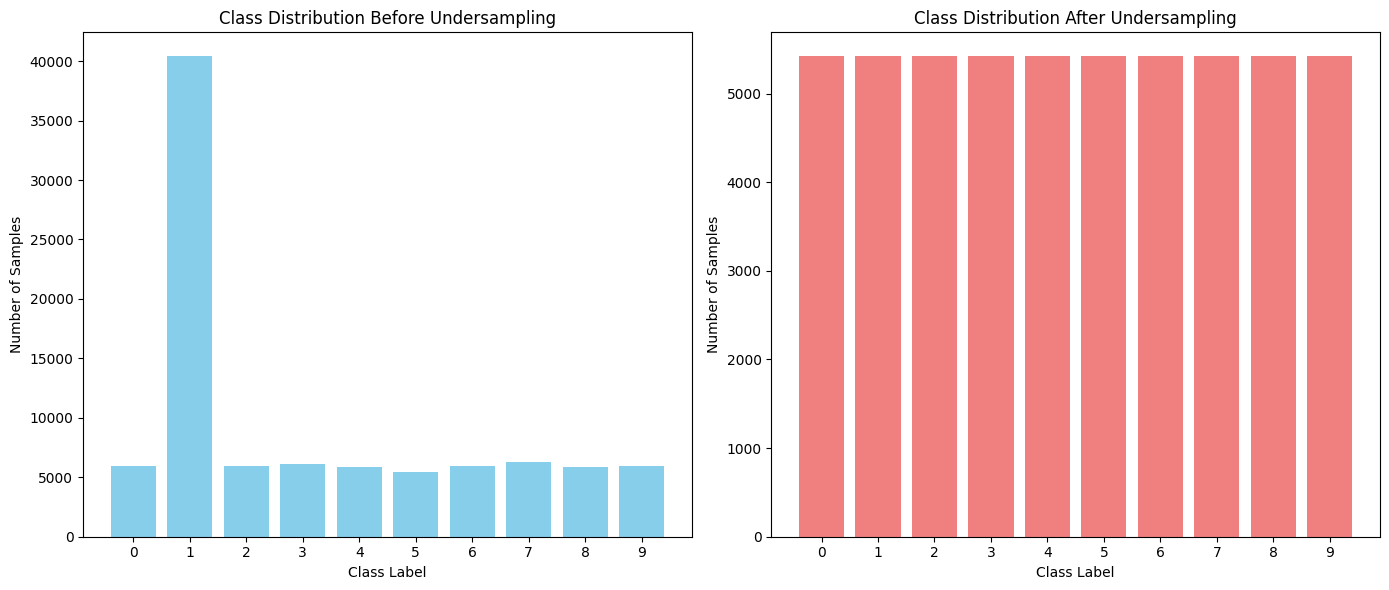

In [14]:
def plot_class_distribution_side_by_side(original_data, undersampled_data):
    original_class_counts = Counter(sample['label'] for sample in original_data)

    undersampled_class_counts = Counter(sample['label'] for sample in undersampled_data)

    original_sorted_labels = sorted(original_class_counts.keys())
    original_sorted_counts = [original_class_counts[label] for label in original_sorted_labels]

    undersampled_sorted_labels = sorted(undersampled_class_counts.keys())
    undersampled_sorted_counts = [undersampled_class_counts[label] for label in undersampled_sorted_labels]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].bar(original_sorted_labels, original_sorted_counts, color='skyblue')
    axes[0].set_xlabel("Class Label")
    axes[0].set_ylabel("Number of Samples")
    axes[0].set_title("Class Distribution Before Undersampling")
    axes[0].set_xticks(original_sorted_labels)

    axes[1].bar(undersampled_sorted_labels, undersampled_sorted_counts, color='lightcoral')
    axes[1].set_xlabel("Class Label")
    axes[1].set_ylabel("Number of Samples")
    axes[1].set_title("Class Distribution After Undersampling")
    axes[1].set_xticks(undersampled_sorted_labels)

    plt.tight_layout()
    plt.show()

undersampled_data = undersample_data(filtered_data)
filtered_data_test = undersample_data(filtered_data_test)

plot_class_distribution_side_by_side(filtered_data, undersampled_data)

### Data Augmentation

The samples in the majority class were significantly reduced through undersampling. To improve classification performance and enhance generalization, data augmentation is a useful technique. By applying transformations such as rotations and scaling to the existing data, new synthetic samples are generated. This increases the diversity of the dataset, particularly for the minority classes, and helps prevent overfitting. With the augmentation, the dataset size increased from 54,200 to 108,400, effectively doubling the available data for training.

In [15]:
def augment_data(dataset, augmentation_factor=2):
    augmented_data = []

    for sample in dataset:
        image = np.array(sample['image'])

        for _ in range(augmentation_factor):
            augmented_image = image.copy()

            # Apply random rotation (between -15 to 15 degrees)
            if random.random() > 0.5:
                angle = random.uniform(-15, 15)
                rotation_matrix = cv2.getRotationMatrix2D((augmented_image.shape[1] // 2, augmented_image.shape[0] // 2), angle, 1)
                augmented_image = cv2.warpAffine(augmented_image, rotation_matrix, (augmented_image.shape[1], augmented_image.shape[0]))

            # Apply random scaling (zoom)
            if random.random() > 0.5:
                scale_factor = random.uniform(0.9, 1.1)
                augmented_image = cv2.resize(augmented_image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)

            # Apply random brightness change
            if random.random() > 0.5:
                brightness_factor = random.uniform(0.7, 1.3)
                augmented_image = np.clip(augmented_image * brightness_factor, 0, 255).astype(np.uint8)

            # Apply random crop if the image size changes after zoom
            if augmented_image.shape[0] > 28 and augmented_image.shape[1] > 28:
                top = random.randint(0, augmented_image.shape[0] - 28)
                left = random.randint(0, augmented_image.shape[1] - 28)
                augmented_image = augmented_image[top:top+28, left:left+28]

            # Ensure the image is resized to 28x28
            augmented_image = cv2.resize(augmented_image, (28, 28), interpolation=cv2.INTER_LINEAR)

            # Add augmented sample to dataset
            augmented_sample = sample.copy()
            augmented_sample['image'] = augmented_image
            augmented_data.append(augmented_sample)

    return augmented_data

augmented_dataset = augment_data(undersampled_data, augmentation_factor=2)

print(f"Original dataset size: {len(undersampled_data)}")
print(f"Augmented dataset size: {len(augmented_dataset)}")


Original dataset size: 54200
Augmented dataset size: 108400


### Visualization of samples by label after undersampling and augumentation

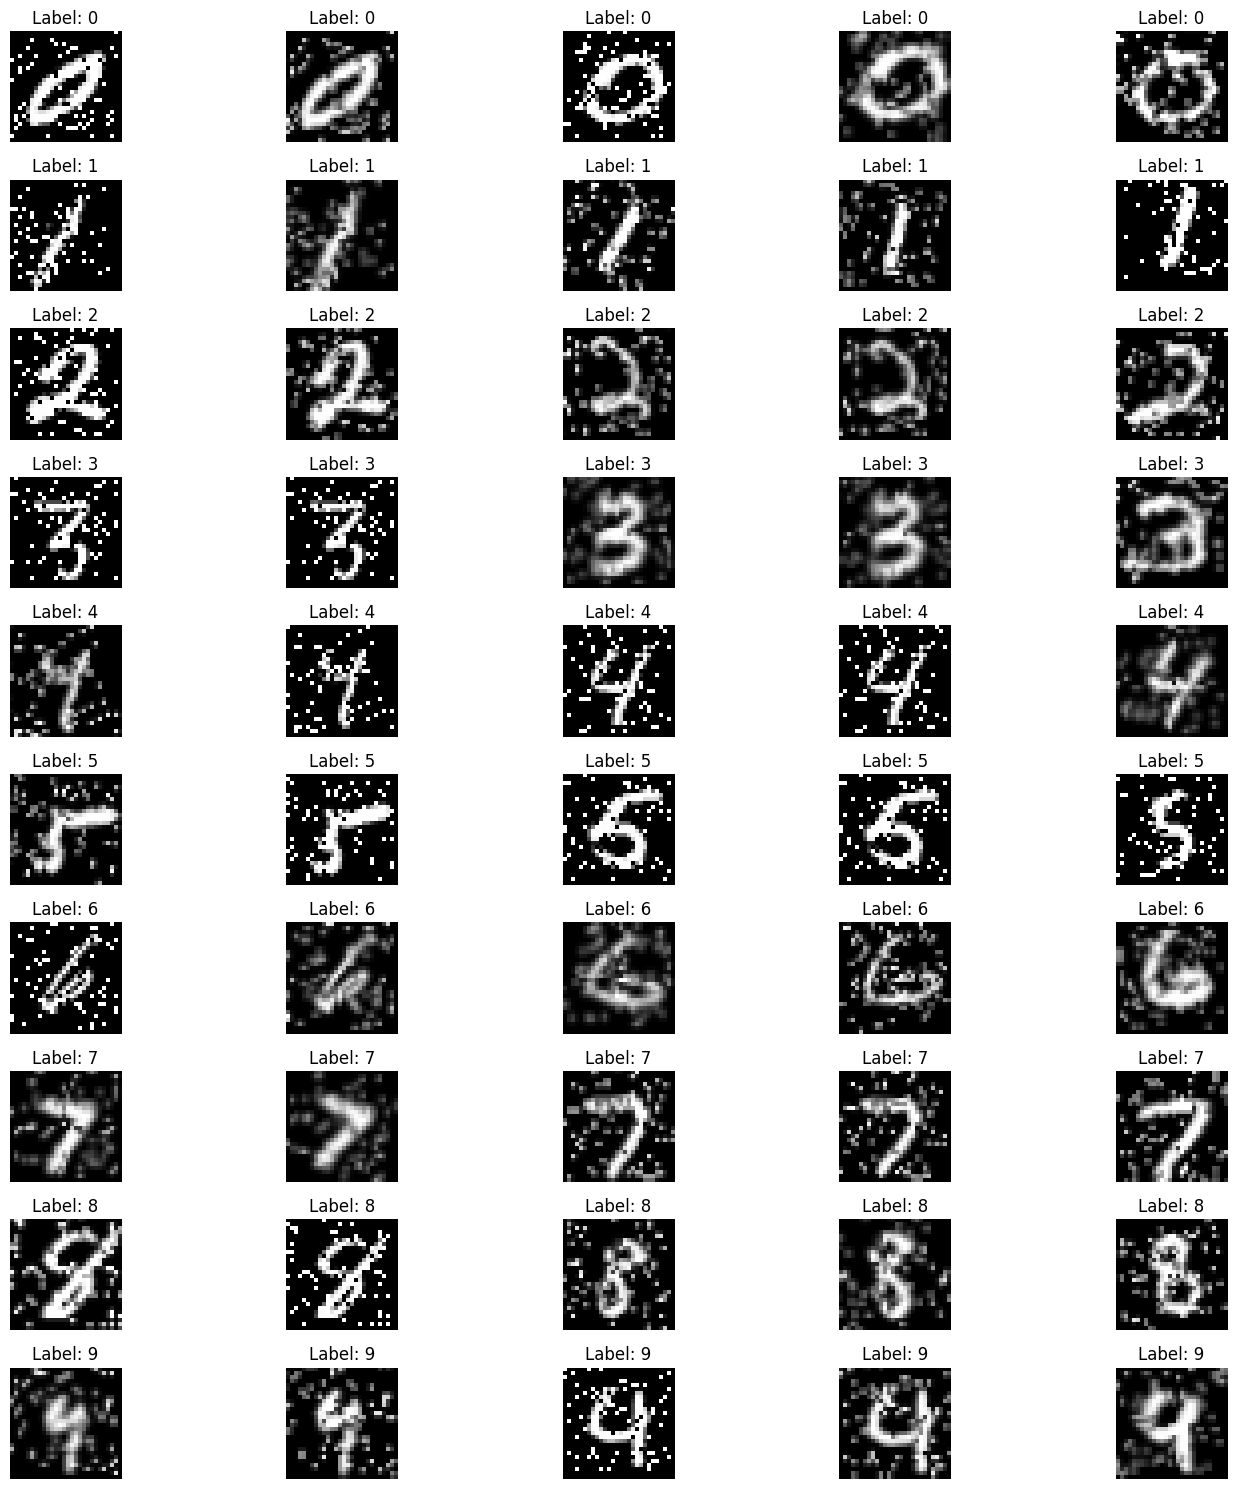

In [16]:
def show_samples_for_each_label(dataset, num_samples=5):
    unique_labels = sorted(set(sample['label'] for sample in dataset))

    num_labels = len(unique_labels)
    num_columns = 5
    num_rows = (num_labels * num_samples + num_columns - 1) // num_columns

    plt.figure(figsize=(15, 15))

    for idx, label in enumerate(unique_labels):
        label_samples = [sample for sample in dataset if sample['label'] == label]

        for i in range(min(num_samples, len(label_samples))):
            image = label_samples[i]['image']
            plt.subplot(num_rows, num_columns, idx * num_samples + i + 1)
            plt.imshow(image, cmap='gray')
            plt.title(f"Label: {label}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

show_samples_for_each_label(augmented_dataset, num_samples=5)


## Image Preprocessing

After filtering out junk samples, consider preprocessing the remaining images.

You could apply some of [image smoothing techniques](https://docs.opencv.org/3.4/d4/d13/tutorial_py_filtering.html) like: **averaging**, **gaussian** or **median blurring** to reduce noise -- noise added to these images has a name and has a standard way of reducing it, you can take a look at popular noises for example [here](https://medium.com/@Coursesteach/computer-vision-part-14-common-types-of-noise-7e6507cc763c). You may also try more advanced denoising techniques, though they might not work well on small images.

Also, [morphological transformations](https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html) like **erosion**, **dilation**, and **opening/closing** can help with noise removal and feature enhancement. However, none of these methods are guaranteed to provide a significant improvement.

In [17]:
sample_image = np.array(augmented_dataset[3]['image'])

### Averaging Blur

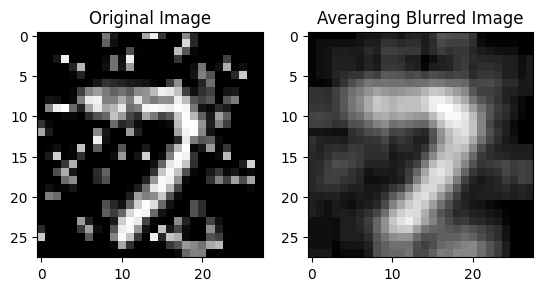

In [18]:
def apply_averaging_blur(image, kernel_size=(5, 5)):
    return cv2.blur(image, kernel_size)

blurred_image = apply_averaging_blur(sample_image)

# Display the original and blurred images
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(blurred_image, cmap='gray')
plt.title("Averaging Blurred Image")
plt.show()

### Gaussian Blur

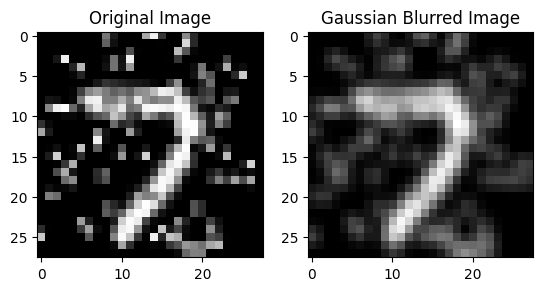

In [19]:
def apply_gaussian_blur(image, kernel_size=(3, 3), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma)

gaussian_blurred_image = apply_gaussian_blur(sample_image)

# Display the original and Gaussian blurred images
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(gaussian_blurred_image, cmap='gray')
plt.title("Gaussian Blurred Image")
plt.show()

### Median Blur

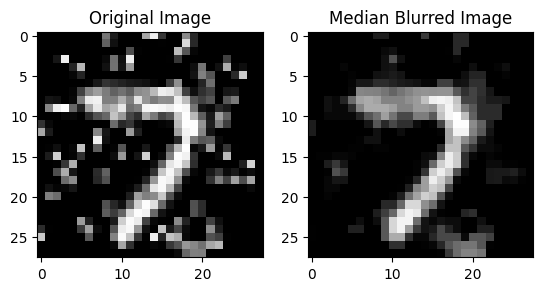

In [20]:
def apply_median_blur(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)

median_blurred_image = apply_median_blur(sample_image)

# Display the original and median blurred images
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(median_blurred_image, cmap='gray')
plt.title("Median Blurred Image")
plt.show()

### Denoising Using Non-Local Means

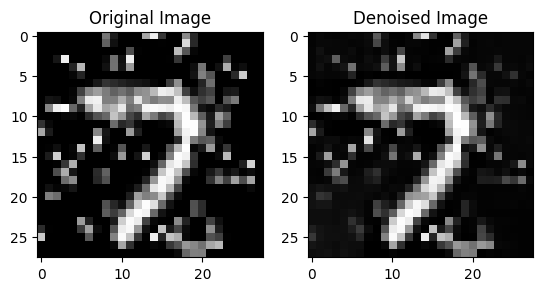

In [21]:
def apply_nl_means_denoising(image):
    return cv2.fastNlMeansDenoising(image, None, 30, 7, 21)

denoised_image = apply_nl_means_denoising(sample_image)

# Display the original and denoised images
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title("Denoised Image")
plt.show()


### Morphological Transformations
**Erosion**: Removes small bright regions (small noise).

**Dilation**: Expands bright regions (useful for enhancing features).

**Opening**: Erosion followed by dilation (useful for removing small noise).

**Closing**: Dilation followed by erosion (useful for closing small holes).

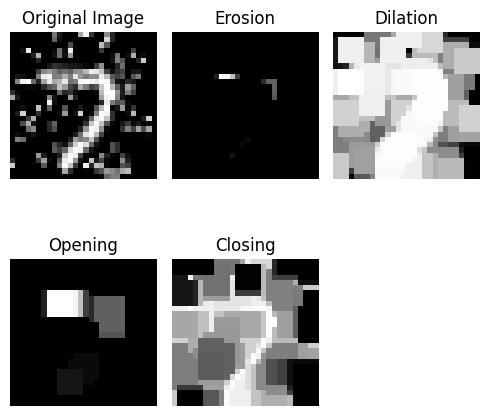

In [22]:
def apply_morphological_transform(image, operation='opening', kernel_size=(5, 5)):
    kernel = np.ones(kernel_size, np.uint8)

    if operation == 'erosion':
        return cv2.erode(image, kernel, iterations=1)
    elif operation == 'dilation':
        return cv2.dilate(image, kernel, iterations=1)
    elif operation == 'opening':
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    elif operation == 'closing':
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    else:
        return image

# Apply the different morphological transformations
morph_erosion = apply_morphological_transform(sample_image, operation='erosion')
morph_dilation = apply_morphological_transform(sample_image, operation='dilation')
morph_opening = apply_morphological_transform(sample_image, operation='opening')
morph_closing = apply_morphological_transform(sample_image, operation='closing')

# Display the original and transformed images
plt.figure(figsize=(5, 5))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Erosion
plt.subplot(2, 3, 2)
plt.imshow(morph_erosion, cmap='gray')
plt.title("Erosion")
plt.axis('off')

# Dilation
plt.subplot(2, 3, 3)
plt.imshow(morph_dilation, cmap='gray')
plt.title("Dilation")
plt.axis('off')

# Opening
plt.subplot(2, 3, 4)
plt.imshow(morph_opening, cmap='gray')
plt.title("Opening")
plt.axis('off')

# Closing
plt.subplot(2, 3, 5)
plt.imshow(morph_closing, cmap='gray')
plt.title("Closing")
plt.axis('off')

plt.tight_layout()
plt.show()


### Combining Preprocessing Techniques

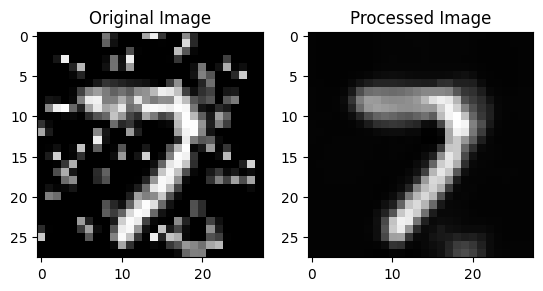

In [23]:
def preprocess_image(image):
    # Apply Median Blur
    blurred_image = apply_median_blur(image, kernel_size=3)

    # Apply denoising
    processed_image = apply_nl_means_denoising(blurred_image)

    return processed_image

# Example usage on a sample image
processed_image = preprocess_image(sample_image)

# Display the original and processed images
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(processed_image, cmap='gray')
plt.title("Processed Image")
plt.show()

### Applying Preprocessing to the Train Dataset

To improve the quality of the images in the dataset, both median blur and denoising techniques will be applied. Median blur helps to reduce noise by replacing each pixel's value with the median of the surrounding pixels, which smooths out irregularities without blurring edges as much as other filters. Denoising, on the other hand, targets unwanted variations in pixel values that may be caused by sensor errors or other factors, effectively cleaning up the image and enhancing its overall quality. Applying these techniques across the entire dataset will help ensure that the images are clearer, more consistent, and suitable for more accurate model training.

In [24]:
processed_dataset = []
for sample in augmented_dataset:
    image_np = np.array(sample['image'])
    processed_image = preprocess_image(image_np)
    processed_sample = sample.copy()
    processed_sample['image'] = processed_image
    processed_dataset.append(processed_sample)


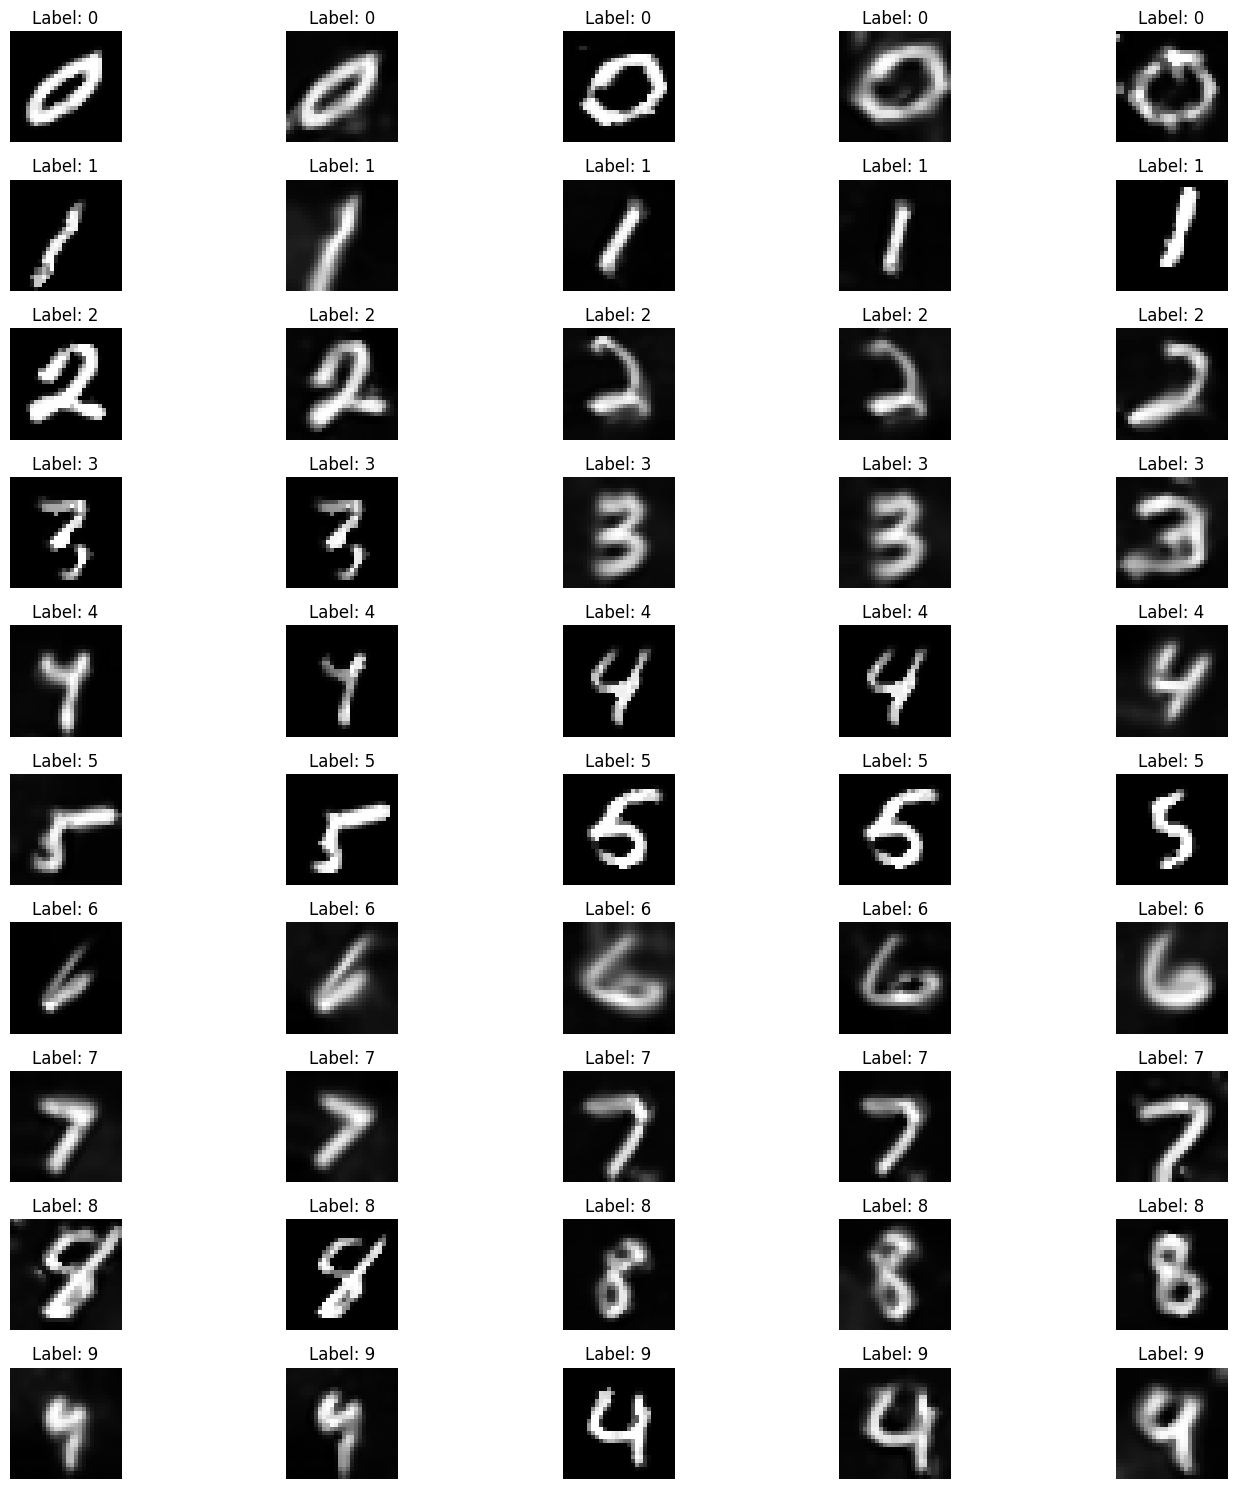

In [25]:
show_samples_for_each_label(processed_dataset, num_samples=5)

### Applying Preprocessing to the Test Dataset

In [26]:
processed_dataset_test = []
for sample in filtered_data_test:
    image_np = np.array(sample['image'])
    processed_image = preprocess_image(image_np)
    processed_sample = sample.copy()
    processed_sample['image'] = processed_image
    processed_dataset_test.append(processed_sample)

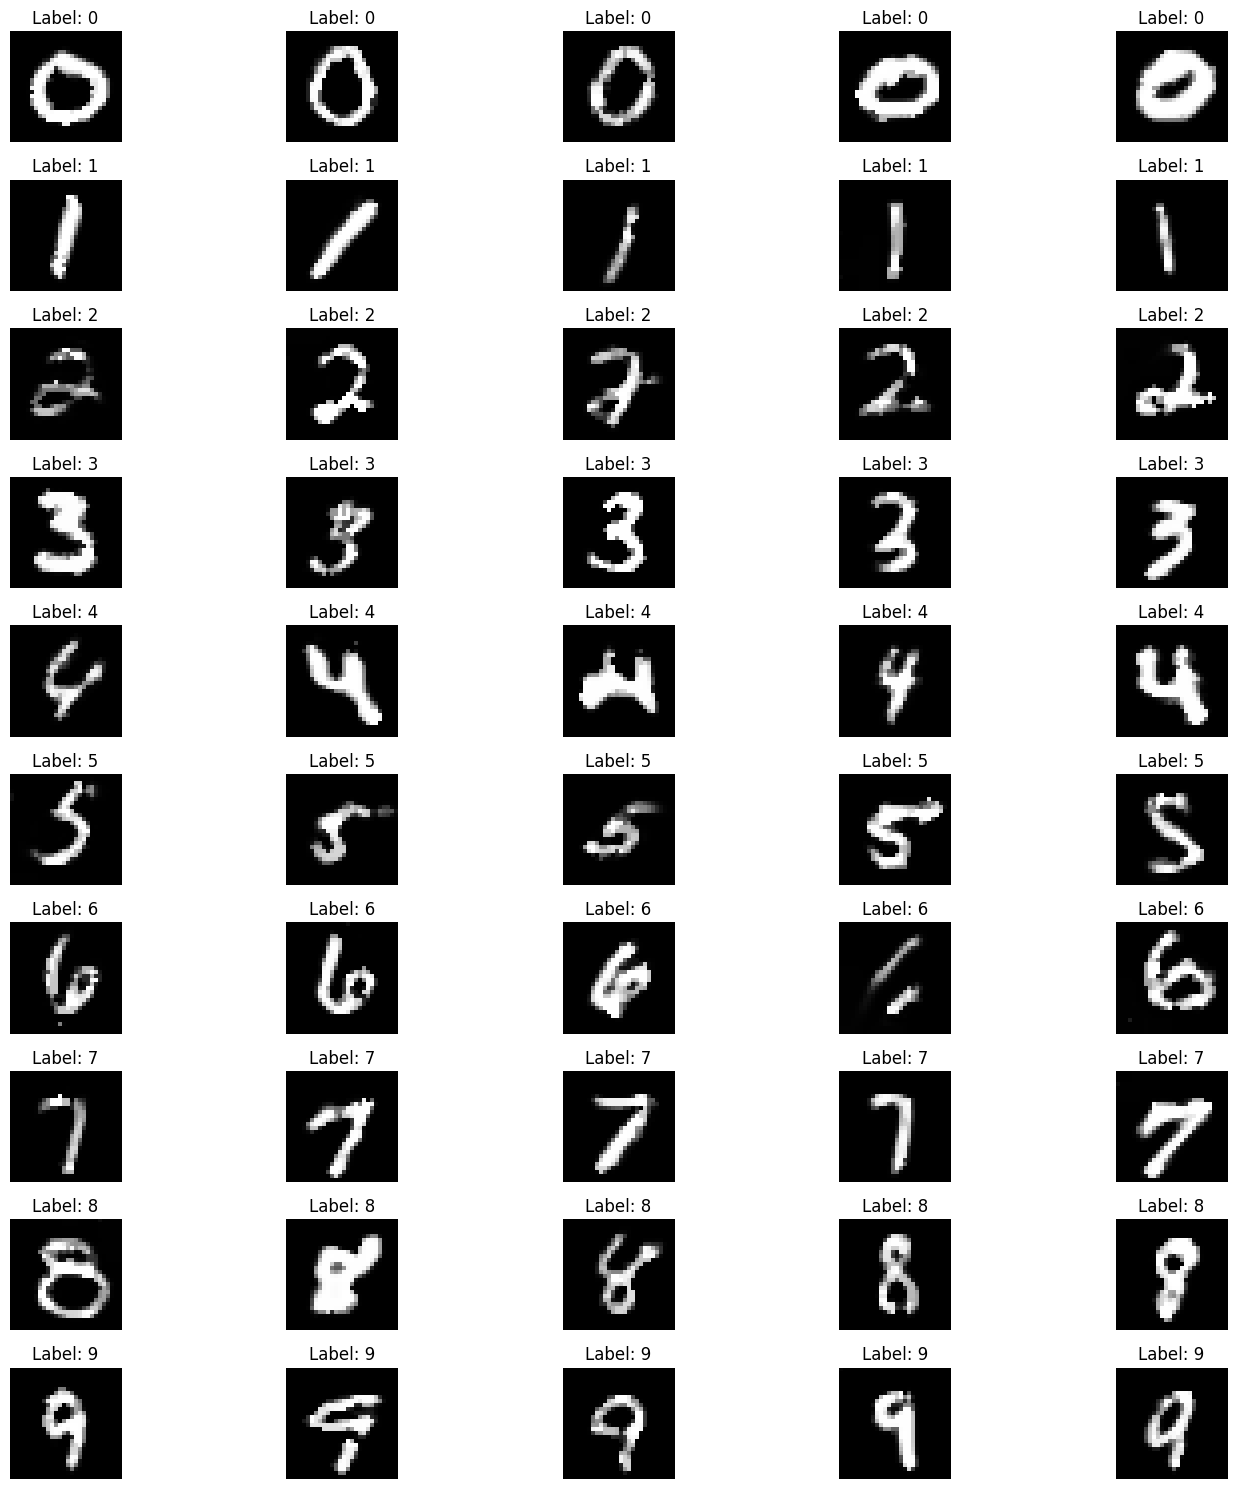

In [27]:
show_samples_for_each_label(processed_dataset_test, num_samples=5)

Let's preprocess the images into numpy array format and normalize it.

In [28]:
X_train = np.array([sample['image'] for sample in processed_dataset])
y_train = np.array([sample['label'] for sample in processed_dataset])

X_test = np.array([sample['image'] for sample in processed_dataset_test])
y_test = np.array([sample['label'] for sample in processed_dataset_test])

print(f"Train data shape: {X_train.shape}, Test data shape: {X_test.shape}")

X_train = X_train / 255.0
X_test = X_test / 255.0

Train data shape: (108400, 28, 28), Test data shape: (8920, 28, 28)


## Feature extraction

Now we will extarct features. Let's choose an image and take a look at some of the features.

In [29]:
image = X_train[6].reshape(28, 28)
label = y_train[6]

**Average Pixel Intensity**

Average pixel intensity represents the mean value of all the pixel intensities in an image. This feature provides insight into the overall brightness or darkness of the digit.

**Standard Deviation of Pixel Intensity**

The standard deviation of pixel intensity measures how much variation there is in the pixel values of the image. A higher standard deviation indicates more contrast, while a lower value suggests more uniform pixel intensities.

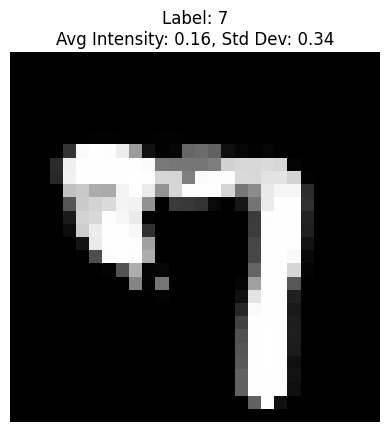

In [30]:
avg_intensity = np.mean(image)
std_intensity = np.std(image)

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}\nAvg Intensity: {avg_intensity:.2f}, Std Dev: {std_intensity:.2f}")
plt.axis('off')
plt.show()

**Pixel Intensity Histogram**

A pixel intensity histogram divides the pixel values into a set of K bins (here 10) and counts how many pixels fall into each bin. This provides a detailed distribution of pixel intensities.

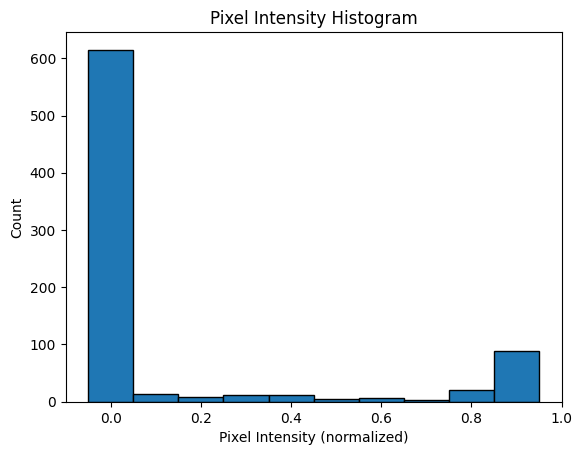

In [31]:
hist_pixels, bins = np.histogram(image, bins=10, range=(0, 1))

plt.bar(bins[:-1], hist_pixels, width=0.1, edgecolor="black")
plt.title("Pixel Intensity Histogram")
plt.xlabel("Pixel Intensity (normalized)")
plt.ylabel("Count")
plt.show()

**Horizontal and Vertical Projections**

Horizontal and vertical projections summarize the distribution of pixel intensities across the rows and columns of the image, respectively. These projections capture the overall structure and alignment of the digit along the horizontal and vertical axes. Horizontal projection sums the pixel intensities for each row, while vertical projection sums them for each column.

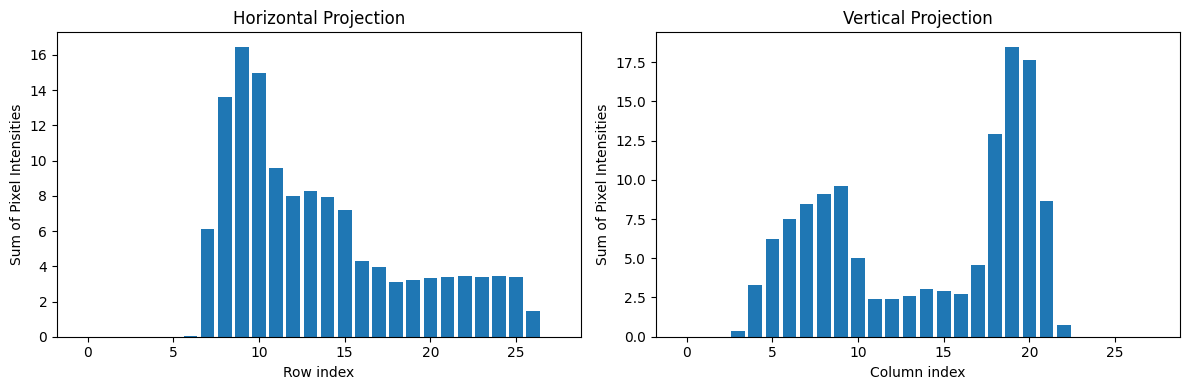

In [32]:
horizontal_projection = np.sum(image, axis=1)
vertical_projection = np.sum(image, axis=0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(range(len(horizontal_projection)), horizontal_projection)
plt.title("Horizontal Projection")
plt.xlabel("Row index")
plt.ylabel("Sum of Pixel Intensities")

plt.subplot(1, 2, 2)
plt.bar(range(len(vertical_projection)), vertical_projection)
plt.title("Vertical Projection")
plt.xlabel("Column index")
plt.ylabel("Sum of Pixel Intensities")

plt.tight_layout()
plt.show()

Try to extract other features like **symmetry**, [Local Binary Patterns (LBP)](https://en.wikipedia.org/wiki/Local_binary_patterns), [Histogram of Oriented Gradients (HOG)](https://builtin.com/articles/histogram-of-oriented-gradients), and [Hu Moments](https://learnopencv.com/tag/hu-moments/), available in *opencv* and *skimage*. These features capture texture, edges, shape, and structural balance in the image. You can also explore **pixel crossings** (the number of times a digit crosses the image's horizontal or vertical centerline).

Experimenting with these features can further improve your model's performance. **Self-learn about possible features** and try to apply them to your dataset for further experimentation.

Now we can write a function to extract features.

In [33]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        image_reshaped = image.reshape(28, 28)


        # Average pixel intensity
        avg_intensity = np.mean(image_reshaped)

        # Standard deviation of pixel intensities
        std_intensity = np.std(image_reshaped)

        # Pixel intensity histogram
        hist_pixels, _ = np.histogram(image_reshaped, bins=10, range=(0, 1))

        # Horizontal and vertical projections
        horizontal_projection = np.sum(image_reshaped, axis=1)
        vertical_projection = np.sum(image_reshaped, axis=0)

        # Symmetry feature (difference between left and right halves)
        left_half = image_reshaped[:, :14]
        right_half = np.fliplr(image_reshaped[:, 14:])
        symmetry = np.mean(np.abs(left_half - right_half))

        # Local Binary Patterns (LBP)
        lbp = local_binary_pattern(image_reshaped.astype(np.uint8), P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
        lbp_hist = lbp_hist / np.sum(lbp_hist)  # Normalize LBP histogram

        # Histogram of Oriented Gradients (HOG)
        hog_features = hog(
            image_reshaped,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(3, 3),
            block_norm='L2-Hys',
            visualize=False
        )

        # Hu Moments (Shape-based features)
        moments = cv2.moments(image_reshaped)
        hu_moments = cv2.HuMoments(moments).flatten()

        # Pixel crossings (crossing the horizontal and vertical centerlines)
        horizontal_centerline = image_reshaped[14, :]  # Middle row
        vertical_centerline = image_reshaped[:, 14]    # Middle column
        horizontal_crossings = np.sum(np.abs(np.diff(horizontal_centerline > 0.5)))
        vertical_crossings = np.sum(np.abs(np.diff(vertical_centerline > 0.5)))

        # Combine all features into a single vector
        feature_vector = np.hstack([
            avg_intensity,              # 1 feature
            std_intensity,              # 1 feature
            hist_pixels,                # 10 features
            horizontal_projection,      # 28 features
            vertical_projection,        # 28 features
            symmetry,                   # 1 feature
            lbp_hist,                   # 10 features
            hog_features,               # HOG features (size depends on the parameters)
            hu_moments,                 # 7 features
            horizontal_crossings,       # 1 feature
            vertical_crossings          # 1 feature
        ])

        features.append(feature_vector)

    features_array = np.array(features)

    return features_array

In [34]:
X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)
print(f"Train features shape: {X_train_features.shape}, Test features shape: {X_test_features.shape}")

100%|██████████| 8920/8920 [00:09<00:00, 975.64it/s] 

Train features shape: (108400, 169), Test features shape: (8920, 169)


## Model training

Now we can evaluate the model on the test set

In [35]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
import time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


Evaluating Classifier: Logistic Regression
Training Time: 21.21 seconds
Accuracy on Test Set: 0.93408
Cross-Validation (5-Fold) Accuracy: 0.91880
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       892
           1       0.96      0.99      0.97       892
           2       0.94      0.94      0.94       892
           3       0.93      0.92      0.92       892
           4       0.92      0.92      0.92       892
           5       0.93      0.93      0.93       892
           6       0.96      0.96      0.96       892
           7       0.92      0.92      0.92       892
           8       0.94      0.89      0.92       892
           9       0.89      0.88      0.88       892

    accuracy                           0.93      8920
   macro avg       0.93      0.93      0.93      8920
weighted avg       0.93      0.93      0.93      8920



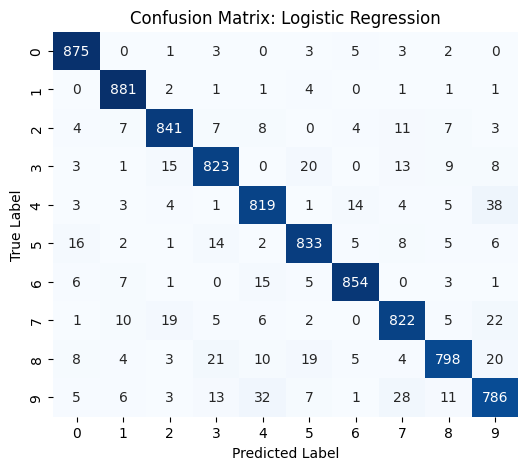


Evaluating Classifier: Random Forest
Training Time: 241.75 seconds
Accuracy on Test Set: 0.93061
Cross-Validation (5-Fold) Accuracy: 0.92003
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       892
           1       0.94      0.99      0.97       892
           2       0.94      0.95      0.95       892
           3       0.90      0.90      0.90       892
           4       0.93      0.93      0.93       892
           5       0.90      0.91      0.91       892
           6       0.96      0.96      0.96       892
           7       0.94      0.92      0.93       892
           8       0.93      0.89      0.91       892
           9       0.89      0.89      0.89       892

    accuracy                           0.93      8920
   macro avg       0.93      0.93      0.93      8920
weighted avg       0.93      0.93      0.93      8920



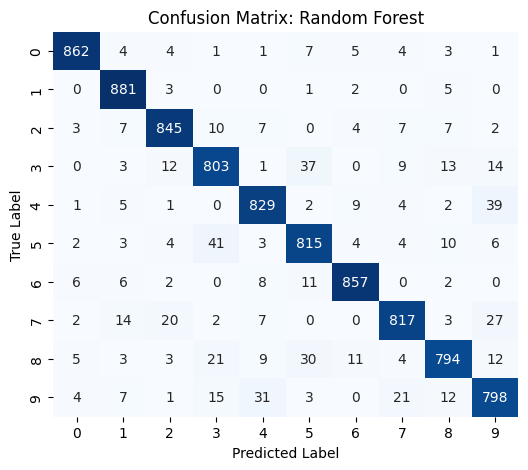


Evaluating Classifier: SVM
Training Time: 246.58 seconds
Accuracy on Test Set: 0.96233
Cross-Validation (5-Fold) Accuracy: 0.95543
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       892
           1       0.97      0.99      0.98       892
           2       0.96      0.98      0.97       892
           3       0.94      0.95      0.94       892
           4       0.95      0.96      0.96       892
           5       0.96      0.96      0.96       892
           6       0.98      0.97      0.98       892
           7       0.95      0.96      0.95       892
           8       0.97      0.95      0.96       892
           9       0.95      0.92      0.94       892

    accuracy                           0.96      8920
   macro avg       0.96      0.96      0.96      8920
weighted avg       0.96      0.96      0.96      8920



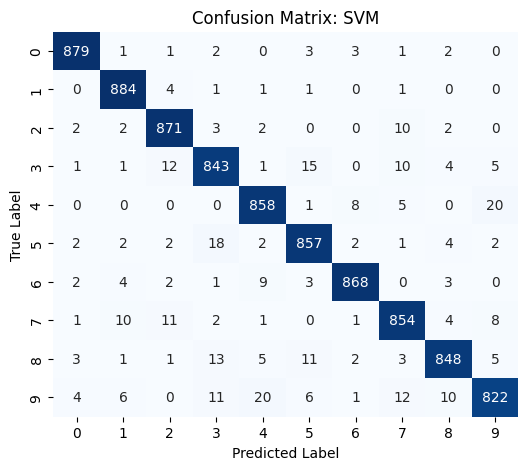


Evaluating Classifier: K-Nearest Neighbors
Training Time: 0.28 seconds
Accuracy on Test Set: 0.92253
Cross-Validation (5-Fold) Accuracy: 0.91444
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       892
           1       0.94      0.99      0.97       892
           2       0.97      0.93      0.95       892
           3       0.90      0.91      0.90       892
           4       0.92      0.90      0.91       892
           5       0.93      0.92      0.92       892
           6       0.95      0.97      0.96       892
           7       0.92      0.89      0.91       892
           8       0.93      0.85      0.89       892
           9       0.84      0.90      0.87       892

    accuracy                           0.92      8920
   macro avg       0.92      0.92      0.92      8920
weighted avg       0.92      0.92      0.92      8920



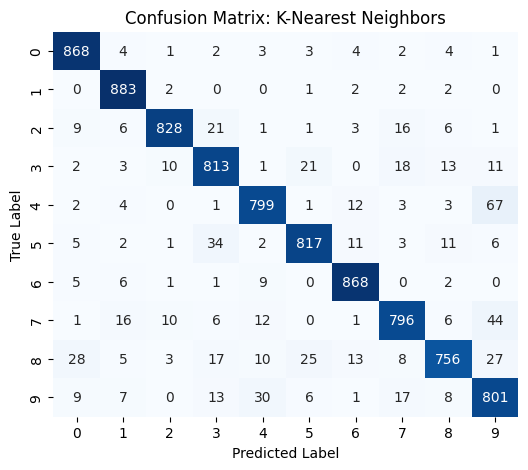

In [36]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Function to plot Confusion Matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {title}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Iterate through classifiers, train, and evaluate
for name, clf in classifiers.items():
    print(f"\nEvaluating Classifier: {name}")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scaling features
        ('classifier', clf)
    ])

    # Measure training time
    start_time = time.time()
    pipeline.fit(X_train_features, y_train)
    training_time = time.time() - start_time

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test_features)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Perform 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pipeline, X_train_features, y_train, cv=kf)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Accuracy on Test Set: {accuracy:.5f}")
    print(f"Cross-Validation (5-Fold) Accuracy: {cv_scores.mean():.5f}")
    print(classification_report(y_test, y_pred))# ,zero_division=1))

    # Plot the confusion matrix
    plot_confusion_matrix(conf_matrix, name)


## Evaluation the model
The Support Vector Machine (SVM) classifier demonstrated the best performance among all models tested, achieving an impressive accuracy of 96.98% on the test set, with a robust 5-fold cross-validation accuracy of 95.54%. This model not only excelled in overall accuracy but also showcased strong precision and recall across all classes, indicating its ability to correctly classify each digit with minimal misclassifications. The SVM model's high F1-scores, which balanced both precision and recall, reflect its effectiveness in handling the dataset's various complexities. While accuracy provides a useful general measure, evaluating the model based on additional metrics like precision, recall, and F1-score offered a more comprehensive understanding of its performance. These metrics highlighted areas where the model performed well, such as on digits with clearer patterns, and revealed opportunities for improvement in more challenging classes. Ultimately, the SVM classifier proved to be the most reliable model for this task, though further optimization and potential ensemble methods could enhance its performance even more.

# Conclusion
This project involved a comprehensive approach to optimize image classification performance. Initially, unlabeled images (label -1), completely black and white images, and those containing noise or rectangles were filtered out. These cleaning steps were applied consistently to both the training and test datasets. Class imbalances in the training set were addressed through data augmentation to improve model generalization.

For image preprocessing, median blur and denoising were selected as the most effective techniques, applied to both datasets to enhance image quality and reduce noise. Feature extraction captured essential patterns, leading to the training of various classifiers. The Support Vector Machine (SVM) emerged as the top performer, achieving an accuracy of 96.98% on the test set with strong precision, recall, and F1-scores across all classes.